In [15]:
import warnings
warnings.filterwarnings('ignore')

![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/EM_spectrum.svg/1920px-EM_spectrum.svg.png)

Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.


ImageView object:
  Display bands       :  (64, 55, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [220.0, 292.0]
    G: [219.0, 284.0]
    B: [208.0, 243.0]

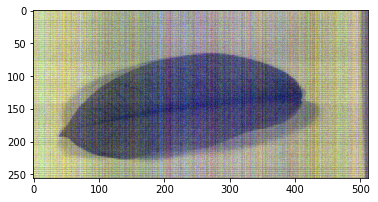

In [16]:
from spectral import imshow, view_cube
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import spectral.io.envi as envi
dark_ref = envi.open('../datasets/bisbul/DARK_REF_2/capture/DARK_REF_2.hdr', '../datasets/bisbul/DARK_REF_2/capture/DARK_REF_2.raw')
white_ref = envi.open('../datasets/bisbul/WHITE_REF_2/capture/WHITE_REF_2.hdr', '../datasets/bisbul/WHITE_REF_2/capture/WHITE_REF_2.raw')
data_ref = envi.open('../datasets/bisbul/BISBUL/capture/BISBUL.hdr', '../datasets/bisbul/BISBUL/capture/BISBUL.raw')

#imshow(data_ref, (110, 5, 18))
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())

imshow(data_nparr, (64, 55, 19))

In [17]:
corrected_nparr = np.divide(
    np.subtract(data_nparr, dark_nparr), 
    np.subtract(white_nparr, dark_nparr))

ImageView object:
  Display bands       :  (32, 32, 32)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-2.25, 3.6666667461395264]
    G: [-2.25, 3.6666667461395264]
    B: [-2.25, 3.6666667461395264]

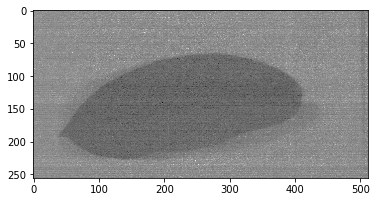

In [18]:
imshow(corrected_nparr, (32, 32, 32))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.08474576473236084, 1.3396226167678833]
    G: [-0.08474576473236084, 1.3396226167678833]
    B: [-0.08474576473236084, 1.3396226167678833]

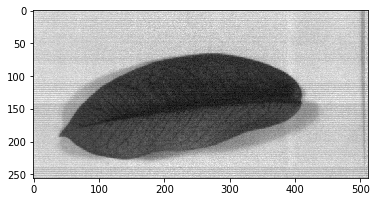

In [19]:
imshow(corrected_nparr, (100, 100, 100))

ImageView object:
  Display bands       :  (200, 200, 200)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.3611111044883728, 1.7599999904632568]
    G: [0.3611111044883728, 1.7599999904632568]
    B: [0.3611111044883728, 1.7599999904632568]

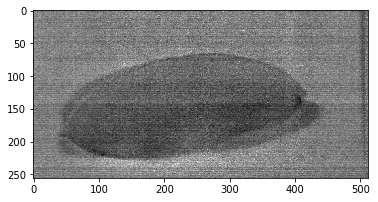

In [20]:
imshow(corrected_nparr, (200, 200, 200))

In [21]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [22]:
leaf_pixel_y = 125
leaf_pixel_x = 200
teflon_pixel_y = 30
teflon_pixel_x = 450

leaf_pixel = corrected_nparr[
    leaf_pixel_y:leaf_pixel_y+1, 
    leaf_pixel_x:leaf_pixel_x+1, 
    :]
teflon_pixel = corrected_nparr[
    teflon_pixel_y:teflon_pixel_y+1, 
    teflon_pixel_x:teflon_pixel_x+1, 
    :]

leaf_pixel_squeezed = np.squeeze(leaf_pixel)
teflon_pixel_squeezed = np.squeeze(teflon_pixel)

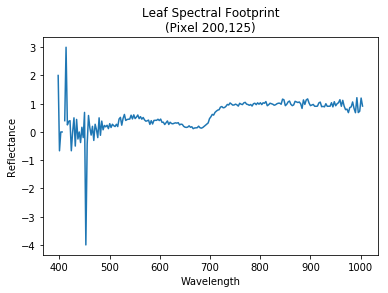

In [23]:
plt.plot(bands, leaf_pixel_squeezed)
plt.title('Leaf Spectral Footprint\n(Pixel {},{})'.format(
    leaf_pixel_x, leaf_pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show()

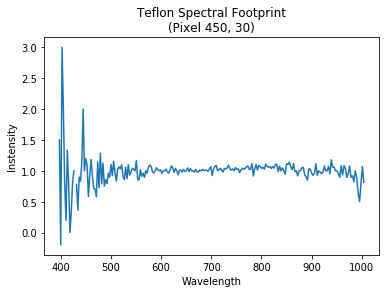

In [24]:
plt.plot(bands, teflon_pixel_squeezed)
plt.title('Teflon Spectral Footprint\n(Pixel {}, {})'.format(
    teflon_pixel_x, teflon_pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Instensity')
plt.show()

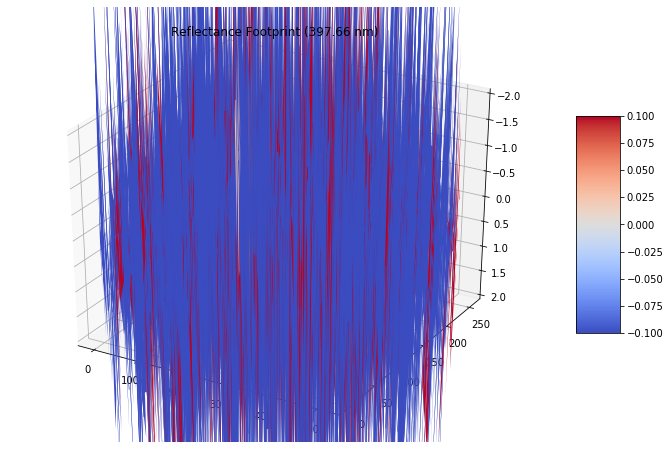

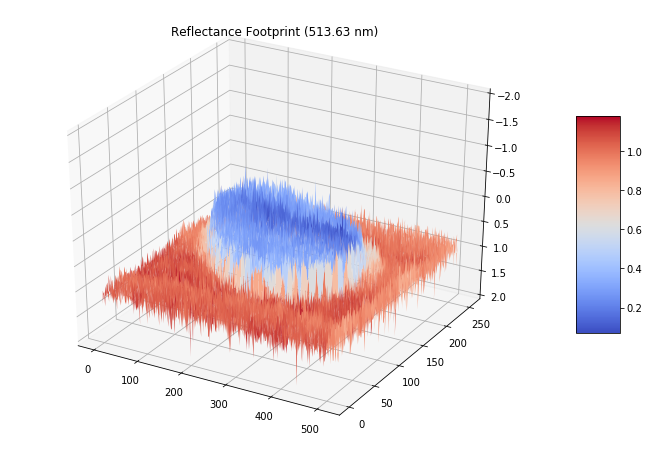

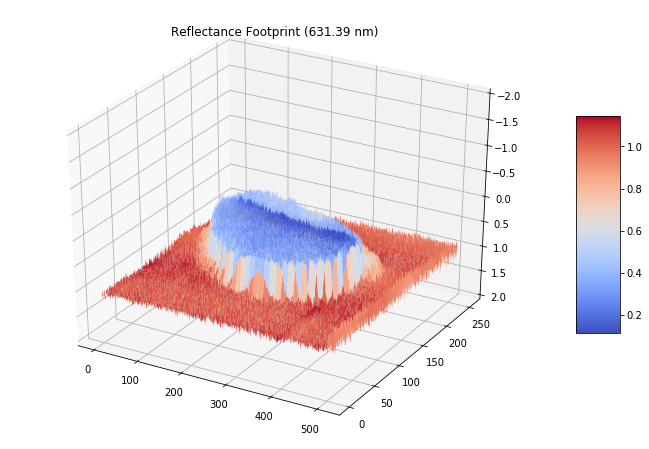

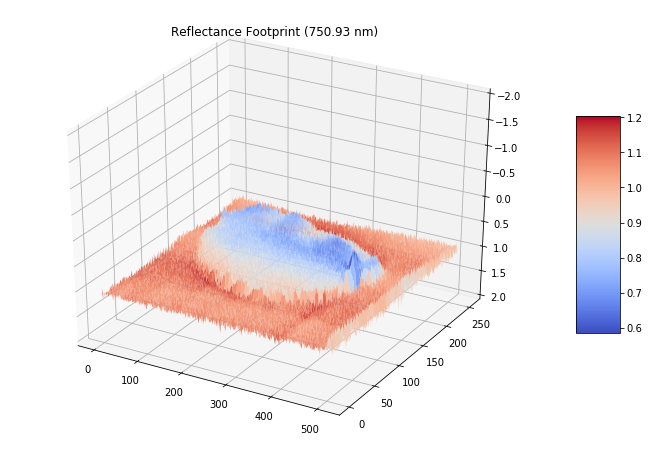

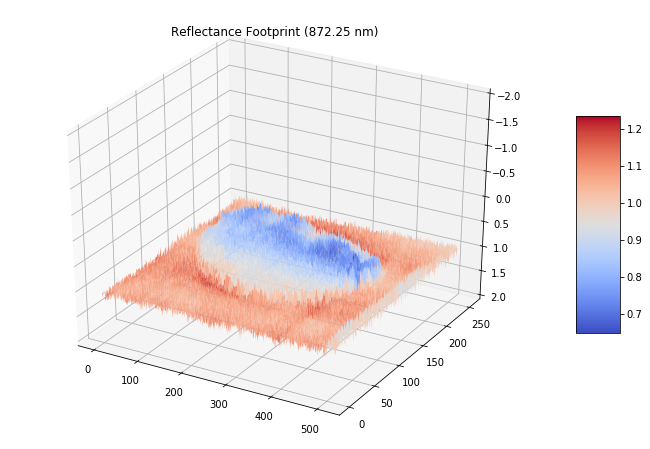

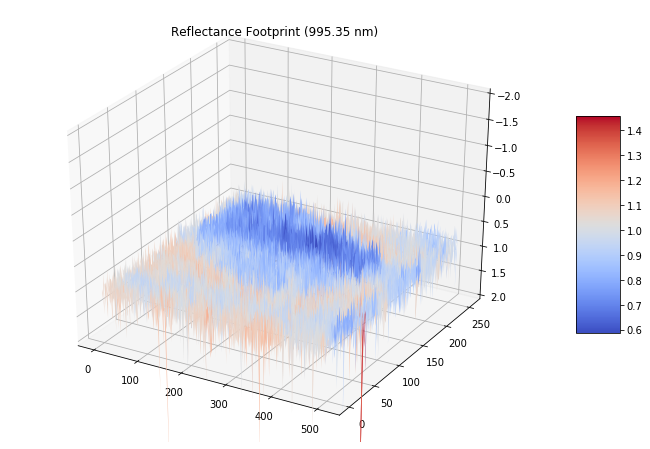

In [25]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for band in range(0, 224, 44):
    X = np.arange(0, 512, 1)
    Y = np.arange(0, 256, 1)
    X, Y = np.meshgrid(X, Y)
    Z = corrected_nparr[:, :, band]
    (X.shape, Y.shape, Z.shape)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)
    ax.set_zlim(-2, 2)
    ax.invert_zaxis()
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Reflectance Footprint ({} nm)'.format(bands[band]))
    plt.show()

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.08474576473236084, 2.0]
    G: [-0.08474576473236084, 2.0]
    B: [-0.08474576473236084, 2.0]

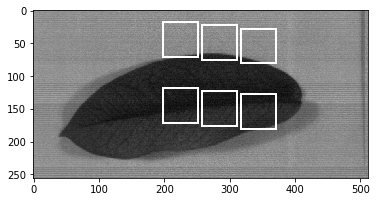

In [26]:
def extract_roi(arr, x, y, w, h, intensity, line):
    roi = arr[y:y+h, x:x+w, :]
    
    bounding_box = arr
    bounding_box[y-line:y, x-line:x+w+line, :] = intensity # garis atas
    bounding_box[y:y+h, x-line:x, :] = intensity # garis kiri
    bounding_box[y+h:y+h+line, x-line:x+w+line, :] = intensity # garis bawah
    bounding_box[y:y+h, x+w:x+w+line, :] = intensity # garis kanan
    
    return (roi, bounding_box)

coordinates = [
    (200, 20), 
    (260, 25), 
    (320, 30), 
    (200, 120), 
    (260, 125), 
    (320, 130)]

rois = [] # returned ROIs
length = 50 # width and height
intensity = 2 # bounding box line intensity
line = 3 # bounding box line width
bounding_boxed = corrected_nparr

for coordinate in coordinates:
    (x, y) = coordinate
    (roi, bounding_boxed) = extract_roi(
        bounding_boxed, x, y, length, length, intensity, line)
    rois.append(roi)

imshow(bounding_boxed, (100, 100, 100))

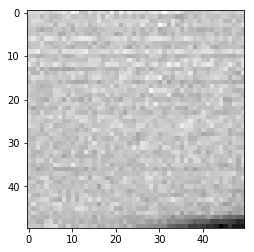

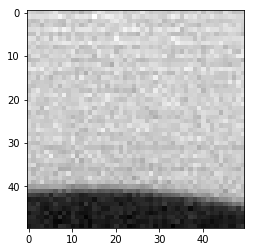

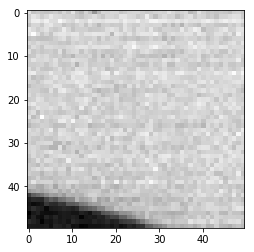

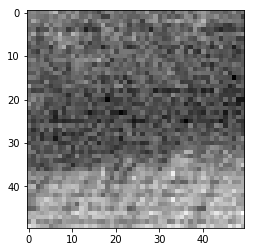

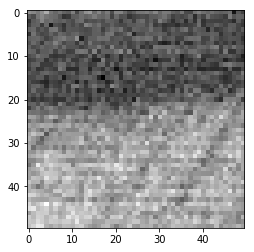

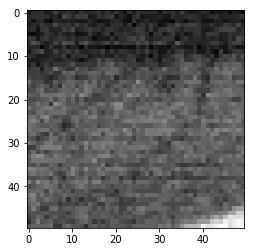

In [27]:
for item in rois:
    imshow(item, (100, 100, 100))

In [28]:
np.save("rois.npy", rois)